### IMPORT LIBRARIES

In [45]:
# DATA MANUPULATION
import numpy as np
import pandas as pd

# DATA VISUALISATION
import matplotlib.pyplot as plt
%matplotlib inline

# DATA PREPROCESSING
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# MODEL GENERATION
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
df = pd.read_csv('C:/Users/LAMAN/Google Drive/Colab Notebooks/TRAININGS/UDEMY/TF & KERAS/Course/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv', parse_dates = True,index_col='DATE')

In [12]:
df.columns = ['Sales']

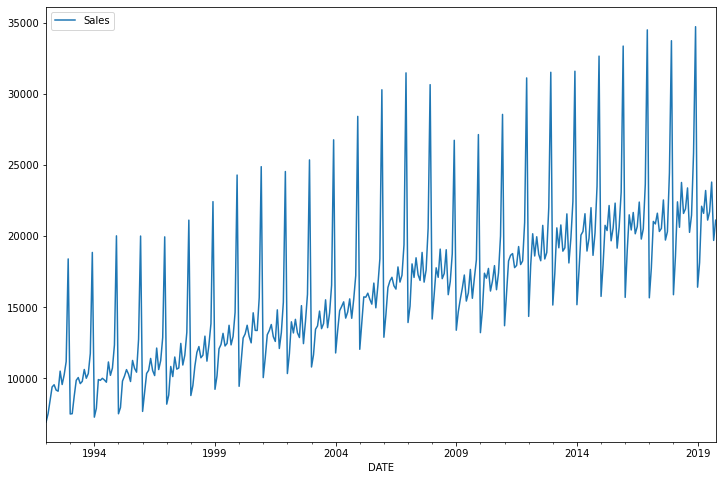

In [13]:
df.plot(figsize = (12,8))

### SPLIT DATA INTO TRAIN-TEST

In [14]:
len(df)

334

In [15]:
len(df) - 18

316

In [16]:
test_size = 18
test_ind = len(df) -test_size

In [17]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

### SCALING THE DATA

In [23]:
scaler = MinMaxScaler()

In [24]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

### GENERATE TIME SERIES

In [28]:
length = 12

generator = TimeseriesGenerator(scaled_train, scaled_train, 
                                length = length, batch_size=1 )

In [29]:
X,y = generator[0]

### GENERATE THE MODEL

In [36]:
n_features = 1

In [41]:
model = Sequential()

model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss ='mse')

In [42]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### CREATE AN EARLYSTOPPING

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [47]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                          length = length, batch_size=1)

In [48]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=early_stop)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
304/304 [==============================] - 10s 33ms/step - loss: 0.0252 - val_loss: 0.0065
Epoch 2/20
304/304 [==============================] - 8s 28ms/step - loss: 0.0181 - val_loss: 0.0038
Epoch 3/20
304/304 [==============================] - 8s 28ms/step - loss: 0.0116 - val_loss: 0.0049
Epoch 4/20
304/304 [==============================] - 6s 18ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 5/20
304/304 [==============================] - 5s 17ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/20
304/304 [==============================] - 5s 18ms/step - loss: 0.0020 - val_loss: 0.0107
Epoch 7/20
304/304 [==============================] - 6s 19ms/step - loss: 0.0015 - val_loss: 0.0037


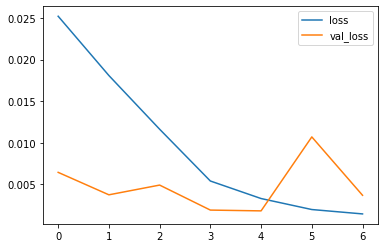

In [50]:
losses = pd.DataFrame(model.history.history).plot()

In [67]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features )

for i in range(len(test)):
    # get prediction 1 time stamp ahead:
    current_pred = model.predict(current_batch)[0]
    
    # store prediction:
    test_predictions.append(current_pred)
    
    # update batch to now include the prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

<ipython-input-68-26b683e1778a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


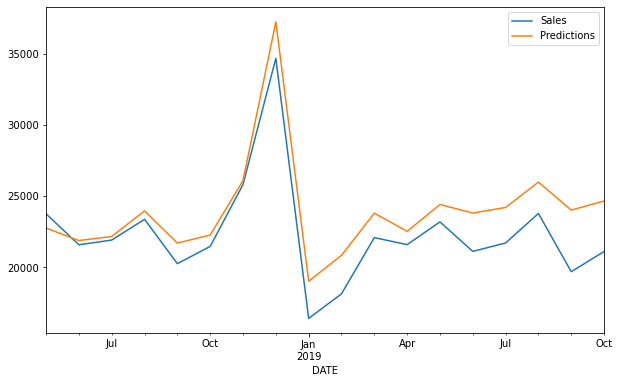

In [68]:
true_pred = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_pred
test.plot(figsize=(10,6))

### FUTERE FORECAST

In [69]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [70]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                               length=length, batch_size=1)

In [71]:
model = Sequential()

model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss ='mse')

In [72]:
model.fit_generator(generator, epochs=4)

Epoch 1/4
322/322 [==============================] - 4s 14ms/step - loss: 0.0266
Epoch 2/4
322/322 [==============================] - 4s 11ms/step - loss: 0.0158
Epoch 3/4
322/322 [==============================] - 4s 11ms/step - loss: 0.0100
Epoch 4/4
322/322 [==============================] - 5s 16ms/step - loss: 0.0051


In [73]:
forecast = []
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features )

for i in range(periods):
    # get prediction 1 time stamp ahead:
    current_pred = model.predict(current_batch)[0]
    
    # store prediction:
    forecast.append(current_pred)
    
    # update batch to now include the prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [74]:
forecast = scaler.inverse_transform(forecast)

In [76]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods,
                              freq='MS')

In [77]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [78]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                          columns=['Forecast'])

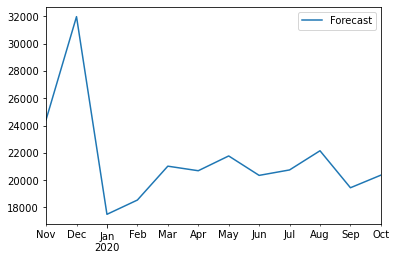

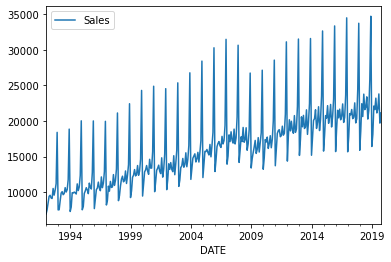

In [80]:
forecast_df.plot()
df.plot()

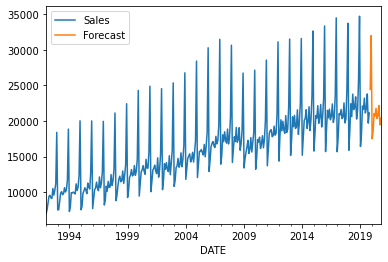

In [81]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

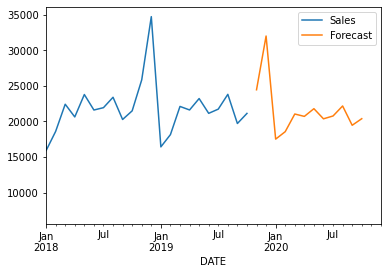

In [82]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')